In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# station_list_with_entry_exit_count
#slist = pd.read_csv("/content/drive/My Drive/Data Links/stations_entry_exit.csv")

#Dhanush Link

#mts_May2_evening mts_May2_morning
slist = pd.read_csv("/content/drive/My Drive/Data Links/Colab Notebooks/mts_May2_evening.csv")

slist_df = pd.DataFrame(slist)

In [8]:
slist.head()

,STATION_ID,NAME,lat,lon,ENTRY_COUNT,EXIT_COUNT
0,MSTN_001,Anacostia,38.862971,-76.995373,1480,2612
1,MSTN_002,Archives-Navy Meml,38.893673,-77.021917,5645,726
2,MSTN_003,Benning Road,38.890983,-76.938367,379,1164
3,MSTN_004,Brookland-CUA,38.933219,-76.994537,1721,2314
4,MSTN_005,Capitol South,38.885070,-77.005142,3497,1048


# Entry

In [9]:
entry_data_slist = slist.loc[slist.index.repeat(slist.ENTRY_COUNT//10)]
#removed //1000

In [10]:
entry_data_slist.head()

,STATION_ID,NAME,lat,lon,ENTRY_COUNT,EXIT_COUNT
0,MSTN_001,Anacostia,38.862971,-76.995373,1480,2612
0,MSTN_001,Anacostia,38.862971,-76.995373,1480,2612
0,MSTN_001,Anacostia,38.862971,-76.995373,1480,2612
0,MSTN_001,Anacostia,38.862971,-76.995373,1480,2612
0,MSTN_001,Anacostia,38.862971,-76.995373,1480,2612


In [11]:
entry_data_slist.size

137874

In [12]:
# DBSCAN 

""" FOR ENTRY COUNT """

import matplotlib.pyplot as plt
from sklearn import cluster
# from geopy.distance import great_circle
# from shapely.geometry import Point

coords_for_entry = entry_data_slist.loc[:,["lat","lon"]]
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = cluster.DBSCAN(eps=epsilon, min_samples=370, algorithm='ball_tree', metric='haversine').fit(np.radians(coords_for_entry))
cluster_labels = db.labels_
range_cluster_labels = np.unique(cluster_labels)
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords_for_entry[cluster_labels == n] for n in range_cluster_labels])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 6


In [13]:
from typing import Tuple
def get_centermost_point(cluster):
    lat_mean, lon_mean = cluster.mean()
    centroid = []
    centroid.append(lat_mean)
    centroid.append(lon_mean)    
    return tuple(centroid)

centermost_points = clusters.map(get_centermost_point)

# Print centroids
centermost_points

0     (38.93812856153884, -77.06374353108714)
1      (38.8979664115829, -77.02725805386373)
2    (38.954652241031546, -77.08253641273627)
3     (38.89485765600013, -77.07010113399998)
4     (38.88316794892936, -77.10838944846364)
5     (38.86237799281135, -77.05248397585808)
dtype: object

In [14]:
lats, lons = zip(*centermost_points)
rep_points_entry = pd.DataFrame({'lon':lons, 'lat':lats})

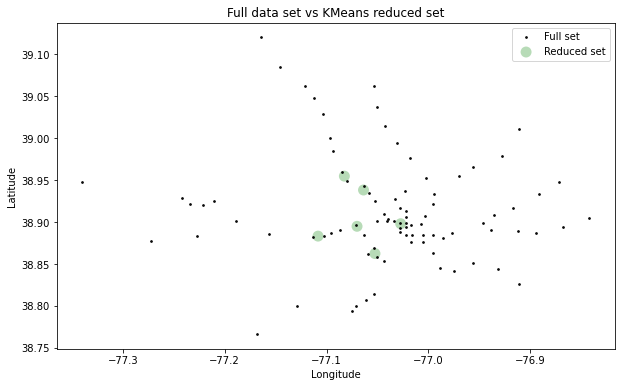

In [15]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rep_points_entry['lon'], rep_points_entry['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(slist_df['lon'], slist_df['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs KMeans reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [16]:
# centermost_points_entry = pd.DataFrame(columns = ['lat', 'lon'])
# Check if chart_studio is installed
import sys
'chart_studio' in sys.modules
# False == not installed

False

In [17]:
!pip install chart_studio

In [18]:
import chart_studio.plotly as py
from plotly.tools import FigureFactory as ff
from chart_studio import tools as tl

tl.set_credentials_file(username='aryapriyank', api_key='B9gB3B6AJrR8OgtXFSTz')
newdata = rep_points_entry.iloc[0:, [1,0]]
table = ff.create_table(newdata)
py.iplot(table, filename='Plot station points on gmap')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:592: UserWarning:

plotly.tools.FigureFactory.create_table is deprecated. Use plotly.figure_factory.create_table



In [19]:
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1IjoiYXJ5YXByaXlhbmsiLCJhIjoiY2wxYjZsbndmMnBjMjNicHd1NWJkems0YiJ9.hSO-JZ6PtffZ5gzsNdTlCw'

site_lat = rep_points_entry.lat
site_lon = rep_points_entry.lon
# locations_name = slist.NAME

data_for_entry_map = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=3,
            color='rgb(255, 0, 0)',
            opacity=1
        ),
        # text=locations_name,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(34, 139, 34)',
            opacity=0.8
        ),
        hoverinfo='none'
    )]



layout_for_entry_map = go.Layout(
    title='station plots',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=38.9,
            lon=-77.1
        ),
        pitch=0,
        zoom=10,
        style='light'
    ),
)


# Generate the figure using the iplot function 
  
fig_entry = dict(data=data_for_entry_map, layout=layout_for_entry_map)
py.iplot(fig_entry, filename='Plot station points on gmap')

# Exit

In [21]:
exit_data_slist = slist.loc[slist.index.repeat(slist.EXIT_COUNT//10)]
#removed //1000

In [22]:
exit_data_slist.size

137868

In [23]:
# DBSCAN 

""" FOR EXIT COUNT """

import matplotlib.pyplot as plt
from sklearn import cluster
# from geopy.distance import great_circle
# from shapely.geometry import Point

coords_for_exit = exit_data_slist.loc[:,["lat","lon"]]
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = cluster.DBSCAN(eps=epsilon, min_samples=370, algorithm='ball_tree', metric='haversine').fit(np.radians(coords_for_exit))
cluster_labels = db.labels_
range_cluster_labels = np.unique(cluster_labels)
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords_for_exit[cluster_labels == n] for n in range_cluster_labels])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 16


In [24]:
from typing import Tuple
def get_centermost_point(cluster):
    lat_mean, lon_mean = cluster.mean()
    centroid = []
    centroid.append(lat_mean)
    centroid.append(lon_mean)
    return tuple(centroid)

centermost_points = clusters.map(get_centermost_point)

# Print centroids
centermost_points

0      (38.94769861075698, -77.03008271724376)
1     (38.902204499976826, -77.02215322562851)
2       (38.9269031403119, -76.99526558767111)
3      (38.93436055787218, -77.05780725378614)
4       (38.95532316588974, -77.0828776969266)
5     (39.119935149999954, -77.16462968000107)
6      (38.99395717999974, -77.03102013000105)
7      (38.94779265999977, -76.87184352999995)
8     (38.895186642519526, -77.07033707629968)
9     (38.885417935694285, -77.10102178583708)
10     (38.87760889999955, -77.27262462000131)
11     (38.86275348151456, -77.05442330309717)
12    (38.826454120000164, -76.91146646999941)
13     (38.80297681006993, -77.06548241358345)
14     (38.76652965000003, -77.16797251000007)
15    (38.947740660000065, -77.34006221999947)
dtype: object

In [25]:
lats, lons = zip(*centermost_points)
rep_points_exit = pd.DataFrame({'lon':lons, 'lat':lats})

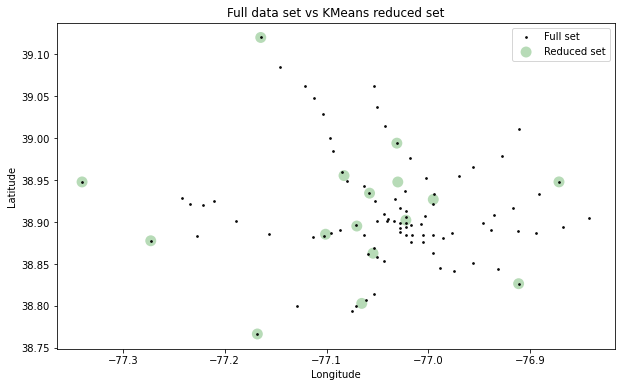

In [26]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rep_points_exit['lon'], rep_points_exit['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(slist_df['lon'], slist_df['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs KMeans reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [27]:
newdata = rep_points_exit.iloc[0:, [1,0]]
table = ff.create_table(newdata)
py.iplot(table, filename='Plot station points on gmap')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:592: UserWarning:

plotly.tools.FigureFactory.create_table is deprecated. Use plotly.figure_factory.create_table



In [28]:
site_lat = rep_points_exit.lat
site_lon = rep_points_exit.lon
# locations_name = slist.NAME

data_for_exit_map = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=3,
            color='rgb(255, 0, 0)',
            opacity=1
        ),
        # text=locations_name,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(242, 68, 55)',
            opacity=0.8
        ),
        hoverinfo='none'
    )]



layout_for_exit_map = go.Layout(
    title='station plots',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=38.9,
            lon=-77.1
        ),
        pitch=0,
        zoom=10,
        style='light'
    ),
)


# Generate the figure using the iplot function 
  
fig_exit = dict(data=data_for_exit_map, layout=layout_for_exit_map)
py.iplot(fig_exit, filename='Plot station points on gmap')

# Combined Plot Test

In [29]:
rep_points_comb = pd.DataFrame(rep_points_entry.append(rep_points_exit, ignore_index = True))
site_lat = rep_points_comb.lat
site_lon = rep_points_comb.lon
# locations_name = slist.NAME

site_lat

0     38.938129
1     38.897966
2     38.954652
3     38.894858
4     38.883168
5     38.862378
6     38.947699
7     38.902204
8     38.926903
9     38.934361
10    38.955323
11    39.119935
12    38.993957
13    38.947793
14    38.895187
15    38.885418
16    38.877609
17    38.862753
18    38.826454
19    38.802977
20    38.766530
21    38.947741
Name: lat, dtype: float64

In [30]:

data_for_comb_map = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=3,
            color='rgb(255, 0, 0)',
            opacity=1
        ),
        # text=locations_name,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(242, 177, 172)',
            opacity=0.8
        ),
        hoverinfo='none'
    )]



layout_for_comb_map = go.Layout(
    title='station plots',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=38.9,
            lon=-77.1
        ),
        pitch=0,
        zoom=10,
        style='light'
    ),
)


# Generate the figure using the iplot function 


# fig_entry = dict(data=data_for_entry_map, layout=layout_for_entry_map)
# fig_exit = dict(data=data_for_exit_map, layout=layout_for_exit_map)
# py.iplot(fig_entry, filename='Plot station points on gmap')
  
fig_comb = dict(data=data_for_comb_map, layout=layout_for_comb_map)
py.iplot(fig_comb, filename='Plot station points on gmap')

# Scatter Plot

In [31]:
import plotly.express as px
# px.set_mapbox_access_token(open(".mapbox_token").read())
px.set_mapbox_access_token(mapbox_access_token)

df = px.data.carshare()
#EXIT_COUNT
fig_entry_sc = px.scatter_mapbox(slist, lat="lat", lon="lon", color="NAME", size="ENTRY_COUNT",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig_entry_sc.show()

In [ ]:
fig_exit_sc = px.scatter_mapbox(slist, lat="lat", lon="lon", color="NAME", size="EXIT_COUNT",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig_exit_sc.show()

# Monday 

In [ ]:
# may trips
mts = pd.read_csv("/content/drive/My Drive/Data Links/od_201605-new.csv")

ParserError: ignored

In [ ]:
mts.head()

In [ ]:
mts.tail()

In [ ]:
mts_df = pd.DataFrame(mts)

In [ ]:
start_date = '02-MAY-16 00:00:00'
end_date = '02-MAY-16 23:59:59'

In [ ]:
mask = (mts_df['ENTRY_DTM'] > start_date) & (mts_df['ENTRY_DTM'] <= end_date)
mts_df_monday = mts_df.loc[mask]

In [ ]:
mts_df_monday.head()

In [ ]:
mts_df_monday.tail()

In [ ]:
print(mts_df.loc[[9604]])

In [ ]:
print(mts_df.loc[[766988]])

In [ ]:
start_date = '02-MAY-16 06:00:00'
end_date = '02-MAY-16 10:00:00'
mask = (mts_df['ENTRY_DTM'] > start_date) & (mts_df['ENTRY_DTM'] <= end_date)
mts_df_monday_entry = mts_df.loc[mask]

In [ ]:
mts_df_monday_entry.size

In [ ]:
start_date = '02-MAY-16 15:00:00'
end_date = '02-MAY-16 19:00:00'
mask = (mts_df['EXIT_DTM'] > start_date) & (mts_df['EXIT_DTM'] <= end_date)
mts_df_monday_exit = mts_df.loc[mask]

In [ ]:
mts_df_monday_exit.size

# Add lat lon to Monday

In [ ]:
mts_df_monday_entry.head()

In [ ]:
mts_df_monday_exit.head()

In [ ]:
from pandas._libs import index
# Entry count
entry_count = mts_df_monday_entry['ENTRY_MSTN_ID'].value_counts().reset_index()
entry_count.columns = ['STATION_ID', 'ENTRY_COUNT']
entry_count.head()

In [ ]:
# Exit count
exit_count = mts_df_monday_exit['EXIT_MSTN_ID'].value_counts().reset_index()
exit_count.columns = ['STATION_ID', 'EXIT_COUNT']
exit_count.head()

In [ ]:
# station_list
slst = pd.read_csv("/content/drive/My Drive/Data Links/stations_corrected.csv")
slst_df = pd.DataFrame(slst)
slst.head()

In [ ]:
entry_data = (slst_df.merge(entry_count, left_on='STATION_ID', right_on='STATION_ID')
          .reindex(columns=['STATION_ID', 'NAME', 'lat', 'lon', 'ENTRY_COUNT']))

In [ ]:
entry_data.head()

In [ ]:
exit_data = (slst_df.merge(exit_count, left_on='STATION_ID', right_on='STATION_ID')
          .reindex(columns=['STATION_ID', 'NAME', 'lat', 'lon', 'EXIT_COUNT']))

In [ ]:
exit_data.head()

# Plot Monday

In [1]:
fig_monday_entry_sc = px.scatter_mapbox(entry_data, lat="lat", lon="lon", color="STATION_ID", size="ENTRY_COUNT",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig_monday_entry_sc.show()

NameError: ignored

In [ ]:
fig_monday_exit_sc = px.scatter_mapbox(exit_data, lat="lat", lon="lon", color="STATION_ID", size="EXIT_COUNT",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig_monday_exit_sc.show()